''' -- coding:utf-8 -- @author: Huaiyu Dong ＆ Yixing Huang @Time: 2023-10-23 @Explanition: This code aims to predict the EAB of microwave absorber structure using the DNN neural network architecture with GA algorithm. '''

In [1]:
###归一化、无数据增强功能###
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Set random seed for PyTorch and NumPy
#seed = 14618
#torch.manual_seed(seed)
#np.random.seed(seed)

# Load your data from mydata_petals.csv
data = pd.read_csv('mydata_petals.csv')

# Extract the last column (EAB) as the target variable
EAB = data.iloc[:, -1].values

# Extract the first 10 columns as input features
input = data.iloc[:, :-1].values

# Create MinMaxScaler objects for input and EAB
scaler_in = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler_out = MinMaxScaler(feature_range=(-0.99, 0.99))

# Fit and transform input data, and store the transformation matrix ps_in
p_scaled = scaler_in.fit_transform(input)
p = torch.FloatTensor(p_scaled.T)
ps_in = scaler_in.scale_

# Fit and transform EAB data, and store the transformation matrix ts_out
t_scaled = scaler_out.fit_transform(EAB.reshape(-1, 1))
t = torch.FloatTensor(t_scaled)
ts_out = scaler_out.scale_

print("Scaled Data Shapes:")
print(p_scaled.shape)
print(t_scaled.shape)

# Define the ratio for training and testing data
train_ratio = 0.8  # 80% training data, 
test_ratio = 0.2   # 20% testing data

# Number of samples
n_samples = len(EAB)

# Create a random permutation of indices for shuffling
indices = np.random.permutation(n_samples)

# Calculate the sizes of the training and test sets
n_train = int(train_ratio * n_samples)
n_test = n_samples - n_train

# Use the shuffled indices to split the data into training and test sets
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data into training and test sets based on the shuffled indices
X_train, y_train = p_scaled[train_indices], t_scaled[train_indices]
X_test, y_test = p_scaled[test_indices], t_scaled[test_indices]

print("Training Data Shapes:")
print(X_train.shape, y_train.shape)
print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

# 打印训练数据前五行
print("First 5 rows of Training Data:")
print(X_train[:5])
print("First 5 rows of Training Target (y_train):")
print(y_train[:5])

print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

# 打印测试数据前五行
print("First 5 rows of Test Data:")
print(X_test[:5])
print("First 5 rows of Test Target (y_test):")
print(y_test[:5])

Scaled Data Shapes:
(2000, 10)
(2000, 1)
Training Data Shapes:
(1600, 10) (1600, 1)
Test Data Shapes:
(400, 10) (400, 1)
First 5 rows of Training Data:
[[-0.04875608 -0.22142857 -0.31938326 -0.0185      0.08286235  0.18343357
  -0.08463779  0.39526412  0.09581056 -0.45415681]
 [ 0.07363454  0.08245614  0.17681217  0.0315      0.06773017 -0.40814653
   0.29031671  0.36775956  0.16557377 -0.44979079]
 [-0.01458393 -0.09348371 -0.31457749 -0.435       0.25041021 -0.2036632
   0.13578449  0.328051    0.18269581 -0.36465345]
 [-0.08006863 -0.14899749  0.13996796 -0.2565     -0.11549681  0.00956807
   0.25555151  0.36520947 -0.12459016  0.16236129]
 [ 0.07063197  0.04411028 -0.22927513 -0.206       0.18040109 -0.06843448
  -0.38532945  0.26010929  0.20637523  0.30680371]]
First 5 rows of Training Target (y_train):
[[0.29373626]
 [0.38076923]
 [0.38076923]
 [0.35901099]
 [0.33725275]]
Test Data Shapes:
(400, 10) (400, 1)
First 5 rows of Test Data:
[[ 0.01344009 -0.36578947 -0.08750501  0.108 

# 仅使用进行遗传算法对权重和偏差进行初始化

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt

# Define your DNN architecture
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Function to evaluate the fitness of an individual (DNN)
def evaluate_fitness(dnn, inputs, targets):
    outputs = dnn(inputs)
    mse = nn.MSELoss()(outputs, targets)
    return mse.item()  # Negative loss as we want to maximize fitness

# Function to train a DNN and return the losses
def train_dnn(dnn, X_train, y_train):
    optimizer = optim.Adam(dnn.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(3000):
        optimizer.zero_grad()
        outputs = dnn(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

# Genetic Algorithm Parameters
population_size = 30
num_generations = 20
mutation_rate = 0.1
crossover_rate = 0.8

# Data
input_dim = 10
output_dim = 1
X_train = torch.FloatTensor(X_train)  # Replace 'your_input_data' with your actual input data
y_train = torch.FloatTensor(y_train)  # Replace 'your_output_data' with your actual output data

# Initialize a population of DNNs
population = [DNN(input_dim, output_dim, [12, 10, 6, 3]) for _ in range(population_size)]

# Empty lists to store generation and fitness data
generations = []
average_fitness_values = []
best_fitness_values = []
worst_fitness_values = []
best_individuals = []
best_losses = []

# Main GA loop
for generation in range(num_generations):
    fitness_scores = []
    generation_losses = []

    for dnn in population:  # Evaluate fitness for each individual in the population
        fitness_score = evaluate_fitness(dnn, X_train, y_train)
        fitness_scores.append(fitness_score)

    generations.append(generation)
    average_fitness = np.mean(fitness_scores)
    average_fitness_values.append(average_fitness)
    best_fitness = np.min(fitness_scores)
    best_fitness_values.append(best_fitness)
    worst_fitness = np.max(fitness_scores)
    worst_fitness_values.append(worst_fitness)

    # Select the top performers
    num_selection = int(population_size * 0.2)
    selected_indices = np.argsort(fitness_scores)[-num_selection:]
    selected_population = [population[i] for i in selected_indices]

    # Crossover
    new_population = []
    while len(new_population) < population_size:
        parent1 = random.choice(selected_population)
        parent2 = random.choice(selected_population)
        if random.random() < crossover_rate:
            child = DNN(input_dim, output_dim, [12, 10, 6, 3])
            for child_param, parent1_param, parent2_param in zip(
                child.parameters(), parent1.parameters(), parent2.parameters()
            ):
                if random.random() < 0.5:
                    child_param.data.copy_(parent1_param.data)
                else:
                    child_param.data.copy_(parent2_param.data)
            new_population.append(child)

    # Mutate
    for i in range(population_size):
        if random.random() < mutation_rate:
            mutated_dnn = DNN(input_dim, output_dim, [12, 10, 6, 3])
            for mutated_param, orig_param in zip(
                mutated_dnn.parameters(), new_population[i].parameters()
            ):
                if random.random() < 0.5:
                    mutated_param.data.copy_(orig_param.data + torch.randn(orig_param.size()))
                else:
                    mutated_param.data.copy_(orig_param.data - torch.randn(orig_param.size()))
            new_population[i] = mutated_dnn

    population = new_population

    # Record the best individual in each generation
    best_individual = min(population, key=lambda dnn: evaluate_fitness(dnn, X_train, y_train))
    best_individuals.append(train_dnn(copy.deepcopy(best_individual), X_train, y_train))
    best_losses.append(evaluate_fitness(best_individual, X_train, y_train))

# Plot average, best, and worst fitness over generations
plt.figure()
plt.plot(generations, average_fitness_values, label='Average Fitness', marker='o', linestyle='-')
plt.plot(generations, best_fitness_values, label='Best Fitness', marker='o', linestyle='-')
plt.plot(generations, worst_fitness_values, label='Worst Fitness', marker='o', linestyle='-')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Over Generations')
plt.grid(True)
plt.legend()
plt.show()

# Plot loss over generations for the best individual
plt.figure()
for i, generation_losses in enumerate(best_individuals):
    plt.plot([i] * len(generation_losses), generation_losses, 'o', markersize=2, label=f'Generation {i}')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.title('Loss Over Generations for the Best Individual')
plt.grid(True)
plt.legend()
plt.show()

Training duration: 0.81 seconds


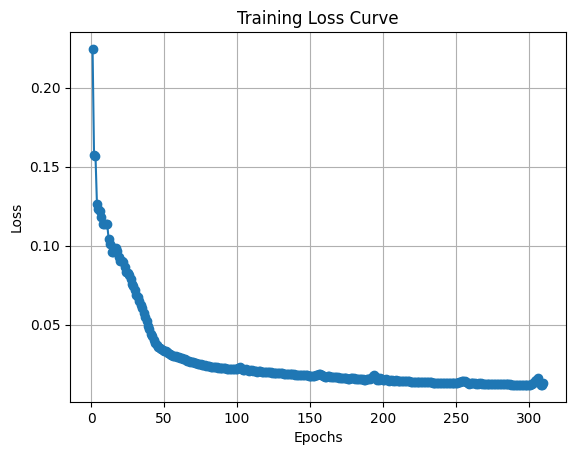

DNN(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=14, bias=True)
    (1): Tanh()
    (2): Linear(in_features=14, out_features=12, bias=True)
    (3): Tanh()
    (4): Linear(in_features=12, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=3, bias=True)
    (7): Tanh()
    (8): Linear(in_features=3, out_features=1, bias=True)
  )
)


In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

# Define your DNN architecture
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the fitness function for GA
def fitness_function(weights, dnn, criterion, inputs, targets):
    start_idx = 0
    for param in dnn.parameters():
        param_size = param.numel()
        param.data = torch.FloatTensor(weights[start_idx:start_idx+param_size]).view(param.size())
        start_idx += param_size

    outputs = dnn(inputs)
    loss = criterion(outputs, targets)
    return loss.item()

# Hyperparameters
input_dim = 10
output_dim = 1
hidden_dims = [14, 12, 8, 3]

# Data
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

# Initialize the DNN
dnn = DNN(input_dim, output_dim, hidden_dims)
criterion = nn.MSELoss()

# Define the problem bounds for GA
num_weights = sum(p.numel() for p in dnn.parameters())
lb = [-1.0] * num_weights
ub = [1.0] * num_weights

# Initialize GA parameters
pop_size =30
max_generations = 10
mutation_rate = 0.1
crossover_rate = 0.8

# Training parameters
external_epochs = 300
learning_rate = 0.02

# Initialize the population
population = [np.random.uniform(lb, ub) for _ in range(pop_size)]

# Record the start time
start_time = time.time()

# Main GA loop
losses = []

for generation in range(max_generations):
    fitness_scores = [fitness_function(individual, dnn, criterion, X_train, y_train) for individual in population]
    best_index = np.argmin(fitness_scores)
    best_individual = population[best_index]

    # Apply the best individual's weights to the DNN
    start_idx = 0
    for param in dnn.parameters():
        param_size = param.numel()
        param.data = torch.FloatTensor(best_individual[start_idx:start_idx+param_size]).view(param.size())
        start_idx += param_size

    losses.append(fitness_scores[best_index])

    # Select the top performers
    num_selection = int(pop_size * 0.2)
    selected_indices = np.argsort(fitness_scores)[:num_selection]
    selected_population = [population[i] for i in selected_indices]

    # Crossover
    new_population = []
    while len(new_population) < pop_size:
        parent1 = random.choice(selected_population)
        parent2 = random.choice(selected_population)
        if random.random() < crossover_rate:
            crossover_point = random.randint(0, num_weights)
            child = list(parent1[:crossover_point]) + list(parent2[crossover_point:])
            new_population.append(child)

    # Mutate
    for i in range(pop_size):
        if random.random() < mutation_rate:
            mutated_individual = np.random.uniform(lb, ub)
            new_population[i] = mutated_individual

    population = new_population

# After GA, continue training with optimized weights
best_individual = population[best_index]  # Use the best individual found by GA
start_idx = 0
for param in dnn.parameters():
    param_size = param.numel()
    param.data = torch.FloatTensor(best_individual[start_idx:start_idx+param_size]).view(param.size())
    start_idx += param_size    
# After GA, continue training with optimized weights
optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
for epoch in range(external_epochs):
    optimizer.zero_grad()
    outputs = dnn(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Record the end time
end_time = time.time()
# Calculate and print the training duration
training_duration = end_time - start_time
print(f"Training duration: {training_duration:.2f} seconds")
# Plot the loss curve
plt.figure()
plt.plot(range(1, max_generations + external_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()
print(dnn)

R-squared (r_train) on training set: 0.868
Mean Absolute Error (MAE) on training set: 0.091
Mean Squared Error (MSE) on training set: 0.013
Root Mean Squared Error (RMSE) on training set: 0.115
R-squared (r_test) on test set: 0.795
Mean Absolute Error (MAE) on test set: 0.110
Mean Squared Error (MSE) on test set: 0.021
Root Mean Squared Error (RMSE) on test set: 0.143


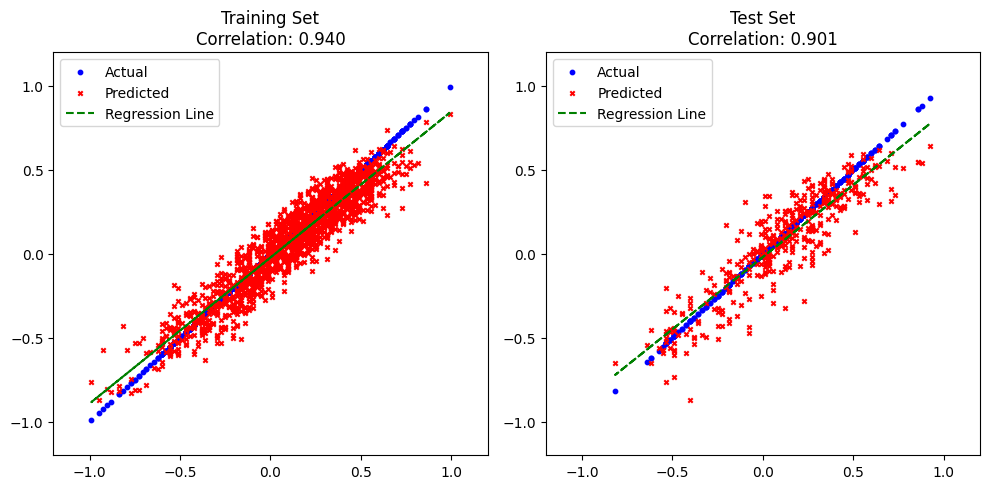

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
with torch.no_grad():
    predicted_train = dnn(torch.FloatTensor(X_train))
    train_true_values = y_train
    r_train = r2_score(train_true_values, predicted_train)
    mae_train = mean_absolute_error(train_true_values, predicted_train)   # MAE training set
    mse_train = mean_squared_error(train_true_values, predicted_train)    # MSE training set
    rmse_train = math.sqrt(mse_train)                               # RMSE training set

print(f"R-squared (r_train) on training set: {r_train:.3f}")
print(f"Mean Absolute Error (MAE) on training set: {mae_train:.3f}")
print(f"Mean Squared Error (MSE) on training set: {mse_train:.3f}")
print(f"Root Mean Squared Error (RMSE) on training set: {rmse_train:.3f}")

with torch.no_grad():              # Perform regression analysis on the test set (X_test, y_test)
    predicted_test = dnn(torch.FloatTensor(X_test))
    test_true_values = y_test
    r_test = r2_score(test_true_values, predicted_test)
    mae_test = mean_absolute_error(test_true_values, predicted_test)   #MAE test set
    mse_test = mean_squared_error(test_true_values, predicted_test)    # MSE test set
    rmse_test = math.sqrt(mse_test)                               #RMSE test set
    predicted_train = dnn(torch.FloatTensor(X_train))

print(f"R-squared (r_test) on test set: {r_test:.3f}")
print(f"Mean Absolute Error (MAE) on test set: {mae_test:.3f}")
print(f"Mean Squared Error (MSE) on test set: {mse_test:.3f}")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse_test:.3f}")
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

actual_train = y_train
actual_test = y_test  # Replace 'y_test' with your test labels

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='x', s=10)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.3f}')
regression_train = LinearRegression()
regression_train.fit(actual_train.reshape(-1, 1), predicted_train)
regression_line_train = regression_train.predict(actual_train.reshape(-1, 1))
axes[0].plot(actual_train, regression_line_train, color='green', linestyle='--', label='Regression Line')
axes[0].legend()

# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='x', s=10)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.3f}')
regression_test = LinearRegression()
regression_test.fit(actual_test.reshape(-1, 1), predicted_test)
regression_line_test = regression_test.predict(actual_test.reshape(-1, 1))
axes[1].plot(actual_test, regression_line_test, color='green', linestyle='--', label='Regression Line')
axes[1].legend()
plt.tight_layout()
plt.show()

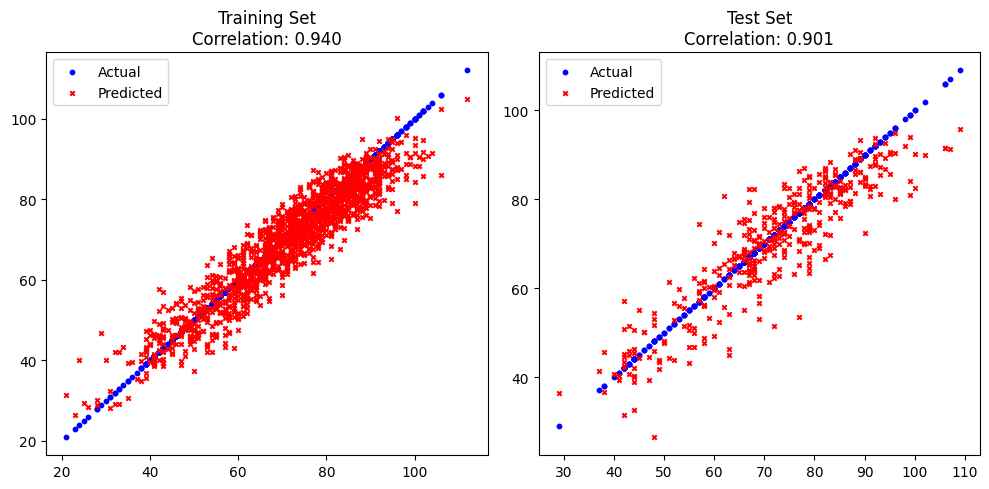

In [4]:
# Transform the predictions back to the original scale
y_train_pred = scaler_out.inverse_transform(predicted_train.reshape(-1, 1)).ravel()
y_test_pred = scaler_out.inverse_transform(predicted_test.reshape(-1, 1)).ravel()
y_train_true = scaler_out.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_true = scaler_out.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Additional code to plot correlation
actual_train = y_train_true
predicted_train = y_train_pred
actual_test = y_test_true
predicted_test = y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='x', s=10)
#axes[0].set_xlim(-1.2, 1.2)
#axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.3f}')
axes[0].legend()


# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='x', s=10)
#axes[1].set_xlim(-1.2, 1.2)
#axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# 输出上图的数据

# 输出预测和实际进行绘图

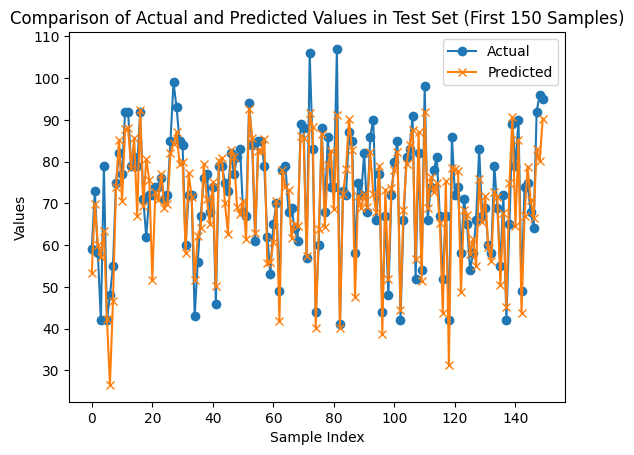

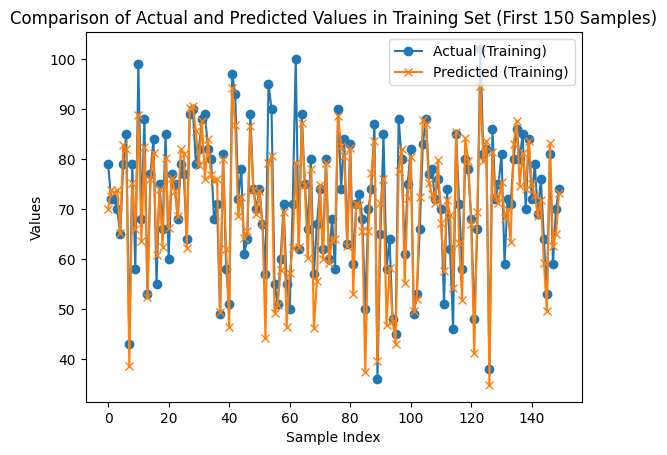

In [5]:
import matplotlib.pyplot as plt
import numpy as np
num_samples_to_plot = 150  # Set the number of samples you want to plot

# Plotting the actual and predicted values for the first 'num_samples_to_plot' samples
plt.plot(actual_test[:num_samples_to_plot], label='Actual', marker='o')
plt.plot(predicted_test[:num_samples_to_plot], label='Predicted', marker='x')

plt.title(f'Comparison of Actual and Predicted Values in Test Set (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the first 'num_samples_to_plot' samples in the training set
plt.plot(actual_train[:num_samples_to_plot], label='Actual (Training)', marker='o')
plt.plot(predicted_train[:num_samples_to_plot], label='Predicted (Training)', marker='x')

plt.title(f'Comparison of Actual and Predicted Values in Training Set (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing code for transforming predictions and plotting correlation

# Save data to a text file
np.savetxt('predicted_actual_train_data.txt', np.column_stack((actual_train, predicted_train)), delimiter=',', header='Actual Train, Predicted Train')
np.savetxt('predicted_actual_test_data.txt', np.column_stack((actual_test, predicted_test)), delimiter=',', header='Actual Test, Predicted Test')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# 遗传算法参与神经网络全过程的寻优

#CPU version #
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define your DNN architecture
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    
# Initialize empty lists to store generation and fitness data
generations = []
average_fitness_values = []
best_fitness_values = []
worst_fitness_values = []
losses = []
# Define a function to evaluate the fitness of an individual (DNN)
def evaluate_fitness(dnn, inputs, targets, learning_rate, max_epochs):
    
    optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        outputs = dnn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    # You can use various metrics to measure fitness
    with torch.no_grad():
        predicted = dnn(inputs)
        mse = criterion(predicted, targets)
        return -mse.item()  # Negative MSE as we want to maximize fitness

# Genetic Algorithm Parameters
population_size = 60
num_generations = 20
mutation_rate = 0.1
crossover_rate = 0.9

# Data
input_dim = 10
output_dim = 1
X_train = torch.FloatTensor(X_train)  # Replace 'your_input_data' with your actual input data
y_train = torch.FloatTensor(y_train)  # Replace 'your_output_data' with your actual output data

# Initialize a population of DNNs
population = [DNN(input_dim, output_dim, [12, 10, 6, 3]) for _ in range(population_size)]

# Main GA loop
for generation in range(num_generations):
    fitness_scores = []
    generation_losses = []  # To store losses for this generation

    for dnn in population:
        fitness_score = evaluate_fitness(dnn, X_train, y_train, learning_rate=0.01, max_epochs= 5)
        fitness_scores.append(fitness_score)

    generations.append(generation)
    average_fitness = np.mean(fitness_scores)
    average_fitness_values.append(average_fitness)
    best_fitness = np.min(fitness_scores)
    best_fitness_values.append(best_fitness)
    worst_fitness = np.max(fitness_scores)
    worst_fitness_values.append(worst_fitness)
    
        # Calculate the loss for each individual in this generation
    for dnn in population:
        optimizer = optim.Adam(dnn.parameters(), lr=0.01)
        criterion = nn.MSELoss()
        optimizer.zero_grad()
        outputs = dnn(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        generation_losses.append(loss.item())
    
    losses.append(generation_losses)
    
    
    # Select the top performers
    num_selection = int(population_size * 0.2)
    selected_indices = np.argsort(fitness_scores)[-num_selection:]
    selected_population = [population[i] for i in selected_indices]

    # Crossover
    new_population = []
    while len(new_population) < population_size:
        parent1 = random.choice(selected_population)
        parent2 = random.choice(selected_population)
        if random.random() < crossover_rate:
            child = DNN(input_dim, output_dim, [12, 10,6, 3])
            for child_param, parent1_param, parent2_param in zip(
                child.parameters(), parent1.parameters(), parent2.parameters()
            ):
                if random.random() < 0.5:
                    child_param.data.copy_(parent1_param.data)
                else:
                    child_param.data.copy_(parent2_param.data)
            new_population.append(child)

    # Mutate
    for i in range(population_size):
        if random.random() < mutation_rate:
            mutated_dnn = DNN(input_dim, output_dim, [12, 10, 6, 3])
            for mutated_param, orig_param in zip(
                mutated_dnn.parameters(), new_population[i].parameters()
            ):
                if random.random() < 0.5:
                    mutated_param.data.copy_(orig_param.data + torch.randn(orig_param.size()))
                else:
                    mutated_param.data.copy_(orig_param.data - torch.randn(orig_param.size()))
            new_population[i] = mutated_dnn

    population = new_population
    


# Find the best individual in the final population
best_dnn = max(population, key=lambda dnn: evaluate_fitness(dnn, X_train, y_train, learning_rate=0.01, max_epochs=3000))
# Continue training the best DNN
best_dnn.train()  # Set the DNN in training mode

# Training with optimized weights
#optimizer = optim.Adam(best_dnn.parameters(), lr=0.01)

#losses = []

#for epoch in range(3000):
    #optimizer.zero_grad()
    #outputs = best_dnn(torch.FloatTensor(X_train))
    #loss = criterion(outputs, torch.FloatTensor(y_train))
    #loss.backward()
    #optimizer.step()
    #losses.append(loss.item())

# Visualize the fitness over generations
plt.figure()
plt.plot(generations, average_fitness_values, label='Average Fitness', marker='o', linestyle='-')
plt.plot(generations, best_fitness_values, label='Best Fitness', marker='o', linestyle='-')
plt.plot(generations, worst_fitness_values, label='Worst Fitness', marker='o', linestyle='-')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Over Generations')
plt.grid(True)
plt.legend()
plt.show()



# Plot the loss curve
#plt.figure()
#plt.plot(range(1, 3001), losses, marker='o', linestyle='-')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.title('Training Loss Curve')
#plt.grid(True)
#plt.show()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Perform regression analysis on the test set (X_test, y_test)
best_dnn.eval()  # Set the best DNN in evaluation mode
with torch.no_grad():
    predicted_test = best_dnn(torch.FloatTensor(X_test))
    true_values = torch.FloatTensor(y_test)
    predicted_train = best_dnn(torch.FloatTensor(X_train))

    r_test = r2_score(true_values, predicted_test)
    m_test = mean_squared_error(true_values, predicted_test)

print(f"R-squared (r_test) on test set: {r_test:.4f}")
print(f"Mean Squared Error (m_test) on test set: {m_test:.4f}")

import matplotlib.pyplot as plt
import numpy as np
import torch 
from sklearn.linear_model import LinearRegression

actual_train = y_train
actual_test = y_test  # Replace 'y_test' with your test labels

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='o', s=10)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.4f}')
#regression_train = LinearRegression()
#regression_train.fit(actual_train.reshape(-1, 1), predicted_train)
#regression_line_train = regression_train.predict(actual_train.reshape(-1, 1))
#axes[0].plot(actual_train, regression_line_train, color='green', linestyle='--', label='Regression Line')
axes[0].legend()

# Scatter plot of actual values and regression line for the test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='o', s=10)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.4f}')
#regression_test = LinearRegression()
#regression_test.fit(actual_test.reshape(-1, 1), predicted_test)
#regression_line_test = regression_test.predict(actual_test.reshape(-1, 1))
#axes[1].plot(actual_test, regression_line_test, color='green', linestyle='--', label='Regression Line')
axes[1].legend()

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np
import torch 
from sklearn.linear_model import LinearRegression

actual_train = y_train
actual_test = y_test  # Replace 'y_test' with your test labels

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='o', s=10)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.4f}')
#regression_train = LinearRegression()
#regression_train.fit(actual_train.reshape(-1, 1), predicted_train)
#regression_line_train = regression_train.predict(actual_train.reshape(-1, 1))
#axes[0].plot(actual_train, regression_line_train, color='green', linestyle='--', label='Regression Line')
axes[0].legend()

# Scatter plot of actual values and regression line for the test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='o', s=10)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.4f}')
#regression_test = LinearRegression()
#regression_test.fit(actual_test.reshape(-1, 1), predicted_test)
#regression_line_test = regression_test.predict(actual_test.reshape(-1, 1))
#axes[1].plot(actual_test, regression_line_test, color='green', linestyle='--', label='Regression Line')
axes[1].legend()

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Set the best DNN to evaluation mode
best_dnn.eval()

# Convert your test data to PyTorch tensor (replace with your test data)
X_test = torch.FloatTensor(X_test)  # Replace with your test data

# Use the best DNN to make predictions
with torch.no_grad():
    predictions = best_dnn(X_test)

# Convert the predictions to a NumPy array
predictions = predictions.numpy()

# Visualize the predictions along with actual values
plt.figure()
plt.plot(predictions, label='Predicted')
plt.plot(y_test, label='Actual')  # Replace 'y_test' with your actual test labels
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.title('DNN Predictions vs. Actual Values')
plt.grid(True)
plt.legend()
plt.show()

# ###无网格搜索功能 架构10-12-10-8-6-1####
kk1 = 12  # Neuron number in 1st hidden layer 
kk2 = 10  # Neuron number in 2nd hidden layer
kk3 = 8  # Neuron number in 3rd hidden layer
kk4 = 6  # Neuron number in 4th hidden layer
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt  # 引入 Matplotlib 库

# Define the architecture of the DNN with hidden layers
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Hyperparameters
input_dim = 10  # Input dimension (adjust as needed)
output_dim = 1  # Output dimension
hidden_dims = [kk1, kk2, kk3, kk4]  # Hidden layer dimensions (adjust as needed)
learning_rate = 0.01  # Learning rate
max_epochs = 1000  # Maximum epochs (adjust as needed)

# Initialize the DNN
dnn = DNN(input_dim, output_dim, hidden_dims)

# Define the optimizer and loss function
optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Convert data to PyTorch tensors
inputs = torch.FloatTensor(X_train)
targets = torch.FloatTensor(y_train)
losses = []
# Train the DNN
for epoch in range(max_epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = dnn(inputs)
    
    # Calculate the loss
    loss = criterion(outputs, targets)
    losses.append(loss.item())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Print loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{max_epochs}], Loss: {loss.item():.4f}")
# 绘制损失曲线
plt.figure()
plt.plot(range(1, max_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()